In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev


In [2]:
rawData = './T47_1330_12152020_timeCorrected.txt'

In [3]:
#Grab header information such as station name date etc...
def headerData(rawData, encoding='ISO-8859-1'):
    start_line = None
    end_line = None
    with open(rawData, 'r', encoding=encoding) as file:
        headerDataHit = False
        for i, line in enumerate(file):
            if 'Launch Date:' in line:
                headerDataHit = True
            elif headerDataHit and 'Profile Data:' in line:
                end_line = i 
                break
            elif headerDataHit and line.strip() and start_line is None:
                #Grabs line where profile data exists
                start_line = i  - 1
    return start_line, end_line
                
    
#Grab profile data which is what contains the raw Radiosonde data
def grabProfileData(rawData, encoding='ISO-8859-1'):
    start_line = None
    end_line = None
    with open(rawData, 'r', encoding=encoding) as file:
        pfDataHit = False
        for i, line in enumerate(file):
            if 'Profile Data' in line:
                pfDataHit = True
            elif pfDataHit and 'Tropopauses:' in line:
                #Mark the line before Tropopauses footer
                end_line = i - 1
                break
            elif pfDataHit and line.strip() and start_line is None:
                #Grabs line where profile data exists
                start_line = i
    return start_line, end_line
    
#Grab troposphere data which is at the footer of the file
def tropoData(rawData, encoding='ISO-8859-1'):
    start_line = None
    end_line = None
    with open(rawData, 'r', encoding=encoding) as file:
        tropoDataHit = False
        for i, line in enumerate(file):
            if '1. Tropopause:' in line:
                tropoDataHit = True
            elif tropoDataHit and 'Reason of Stop Sounding:' in line:
                end_line = i 
                break
            elif tropoDataHit and line.strip() and start_line is None:
                #Grabs line where profile data exists
                start_line = i -1
    return start_line, end_line
                
    

In [4]:
#Uses appropriate functions to apply the profiles into dataframes if there is some error with the format of the file it will not create the dataframe
data_start_line, data_end_line = headerData(rawData)
if data_start_line is not None and data_end_line is not None:
    nrows_to_read = data_end_line - data_start_line
    header_df = pd.read_csv(rawData, sep='\t', skiprows=data_start_line, nrows=nrows_to_read, engine='python', encoding='ISO-8859-1', header=None)

data_start_line, data_end_line = grabProfileData(rawData)
if data_start_line is not None and data_end_line is not None:
    nrows_to_read = data_end_line - data_start_line
    profile_df = pd.read_csv(rawData, sep='\t', skiprows=data_start_line, nrows=nrows_to_read, engine='python', encoding='ISO-8859-1')
    #profile_df.columns += profile_df.iloc[0]
    profile_df.rename(columns=lambda x: x.strip(), inplace=True)
    profile_df = profile_df[1:]


data_start_line, data_end_line = tropoData(rawData)
if data_start_line is not None and data_end_line is not None:
    nrows_to_read = data_end_line - data_start_line
    tropo_df = pd.read_csv(rawData, sep='\t', skiprows=data_start_line, nrows=nrows_to_read, engine='python', encoding='ISO-8859-1')

In [5]:
header_df = header_df.dropna(axis=1, how="all")
header_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Launch Date:,,,"Tuesday, 15 December 2020",,,,Launch Time:,,,13:35:21,,,End of Ascent:,,,02:02:24
1,Station name:,,,OKSTATE USRI,,,,Serialnumber:,,,20027941,None,None,None,None,None,None
2,Ground values:,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Pressure:,,,1021.6 hPa,,,,Temperature:,,,13.4 °C,,,Humidity:,,,61 %
4,Wind Direction:,,,142 °,,,,Wind Speed:,,,2 m/s,,,Cloud group:,,,9////
5,Position:,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Longitude:,,,-73.160 °,,,,Latitude:,,,-39.236 °,,,Altitude:,,,3 m
7,Staff:,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Company:,,,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Operator:,,,,,,,NaN,None,None,None,None,None,None,None,None,None


In [6]:
profile_df

,Time,P,T,Hu,Ws,Wd,Long.,Lat.,Alt,Geopot,MRI,RI,Dewp.,Virt. Temp,Rs,Elevation,Azimuth,Range,D
1,0,1021.6,13.4,61,2.1,142,-73.160460,-39.236350,3,3,279.899,279.428,6.1,14.4,0.0,39.2,180,0,1.242220
2,1,1021.3,13.2,60,2.3,141,-73.160545,-39.236311,5,5,280.276,279.475,5.5,14.2,2.1,16.0,298,9,1.242702
3,2,1021.1,13.0,58,2.5,139,-73.160631,-39.236273,7,7,280.668,279.522,5.0,14.0,2.1,15.2,299,17,1.243185
4,3,1020.8,12.8,57,2.7,138,-73.160716,-39.236234,9,9,281.044,279.568,4.5,13.7,2.1,14.8,299,26,1.243668
5,4,1020.6,12.7,55,2.9,138,-73.160802,-39.236196,12,12,281.420,279.615,4.0,13.5,2.1,14.5,300,35,1.244152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8851,8850,75.4,-57.9,3,11.8,237,-72.567347,-38.219557,18171,18109,2880.330,27.420,-81.1,-57.9,-2.2,7.8,025,125594,0.121977
8852,8851,75.4,-57.9,3,11.9,237,-72.567230,-38.219504,18169,18107,2880.000,27.436,-81.1,-57.9,-2.2,7.8,025,125604,0.122040
8853,8852,75.4,-57.9,3,11.9,237,-72.567114,-38.219451,18167,18105,2879.671,27.452,-81.1,-57.9,-2.2,7.8,025,125613,0.122104
8854,8853,75.4,-58.0,3,11.9,237,-72.566997,-38.219398,18165,18103,2879.325,27.468,-81.0,-58.0,-2.2,7.8,025,125622,0.122167


In [7]:
#Convert columns to type integer
for col in profile_df.select_dtypes(include=['object']).columns:
    profile_df[col] = pd.to_numeric(profile_df[col], downcast='integer')

In [8]:
profile_df['T'][1]

13.4

In [21]:
def graph2d(x, y, deg, x_label, y_label, title):
    # Scatter plot
    plt.figure()
    plt.scatter(x, y, s=5, label='Data points')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    plt.show()

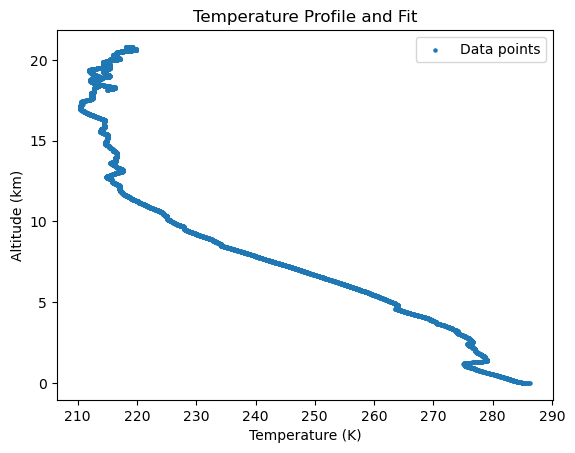

In [22]:

graph2d(profile_df['T'] + 273, profile_df['Alt'] / 1000, 3,'Temperature (K)', 'Altitude (km)', 'Temperature Profile and Fit')


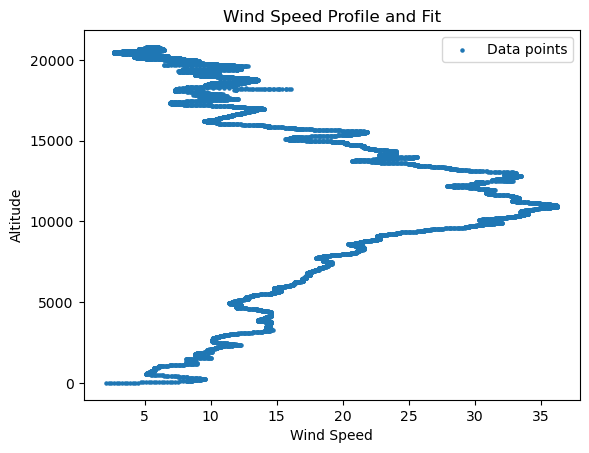

In [23]:
graph2d(profile_df['Ws'], profile_df['Alt'],3 ,'Wind Speed', 'Altitude', 'Wind Speed Profile and Fit')